# **Project: S&OP "Broken Chain" Simulation Generator**
**Purpose:** Generates a synthetic dataset and visualization suite for a Sales & Operations Planning (S&OP) Workshop.

## **Overview**
This notebook simulates a common business dilemma: **"Revenue vs. Profitability."**
We create a fictional 3-year history for a personal care brand ("Halo") with two conflicting product lines:
1.  **Halo Core:** Reliable, high-margin, boring.
2.  **Halo Gold:** Unreliable, low-margin, high-growth "shiny object."

**The Goal:** The data is engineered to force a "Kill the Product" decision by exposing hidden costs and brand damage.

**Tech Stack:** Python (Pandas for data, Seaborn for visuals).

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter
from IPython.display import display, Markdown

# Setup Output Directory
OUTPUT_DIR = 'SOP_Workshop_Repo_Final'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# --- CONFIGURATION ---
timeline = pd.date_range(start='2023-01-01', end='2025-12-31', freq='W')
num_years = len(timeline) / 52.1775

CONFIG = {
    'timeline': timeline,
    'years_factor': num_years,
    'vol_core_weekly': 12000,    # Core Base Volume
    'vol_gold_weekly': 2500,     # Gold Base Volume
    'promo_multiplier': 4.0,     # Promo Lift (4x)
    'margin_core_base': 0.55,    # Core Margin
    'margin_gold_base': 0.25,    # Gold Margin (Base)
    'margin_gold_promo': 0.10,   # Gold Margin (Promo - The Trap)
}

# Product Portfolio
portfolio = [
    {'sku': 'Halo Core - Shampoo',  'type': 'Halo Core (Local)',   'price': 14, 'lead_time': 5},
    {'sku': 'Halo Core - Cond.',    'type': 'Halo Core (Local)',   'price': 16, 'lead_time': 7},
    {'sku': 'Halo Gold - Argan',    'type': 'Halo Gold (Import)',  'price': 28, 'lead_time': 45},
    {'sku': 'Halo Gold - Truffle',  'type': 'Halo Gold (Import)',  'price': 32, 'lead_time': 50}
]

# Sales Channels
channel_seq = ['Hypermarket']*10 + ['Supermarket']*6 + ['E-commerce']*3 + ['Convenience']*1

# Failure Reasons (Deterministic)
gold_stockout_reasons = (
    ['Route Blockage (External)'] * 4 + 
    ['Port Congestion'] * 2 + 
    ['Vessel Delay']
)
core_stockout_reasons = ['Quality Hold (Internal)', 'Line Breakdown', 'Material Shortage']

print("✅ Configuration Loaded.")

✅ Configuration Loaded.


---
## **Block 2: Transaction Data Engine**
**What this does:** Simulates day-to-day operations for 3 years.

It loops through every week and applies the **"50% Failure Rule"** to Halo Gold.
* **Halo Gold:** Fails every other shipment (50% stockout rate).
* **Halo Core:** Fails rarely (1% stockout rate).

This creates the operational "mess" that Supply Chain has to deal with.

In [9]:
rows = []
global_counter = 0
gold_fail_counter = 0
core_fail_counter = 0

for date in CONFIG['timeline']:
    for prod in portfolio:
        channel = channel_seq[global_counter % len(channel_seq)]
        week_num = date.week
        
        # 1. Demand & Seasonality
        if 'Halo Core' in prod['type']: base_vol = CONFIG['vol_core_weekly']
        else: base_vol = CONFIG['vol_gold_weekly']
        
        seasonality = int(base_vol * 0.15 * np.sin(week_num / 52 * 2 * np.pi))
        base_demand = base_vol + seasonality
        is_promo = 1 if week_num % 6 == 0 else 0
        
        # 2. Supply Failure Logic
        is_stockout = 0
        reason = "Available"
        if 'Halo Gold' in prod['type']:
            if global_counter % 2 == 0: # Exactly 50% Failure
                is_stockout = 1
                reason = gold_stockout_reasons[gold_fail_counter % len(gold_stockout_reasons)]
                gold_fail_counter += 1
        else:
            if global_counter % 100 == 0: # Exactly 1% Failure
                is_stockout = 1
                reason = core_stockout_reasons[core_fail_counter % len(core_stockout_reasons)]
                core_fail_counter += 1
        
        rows.append([date, prod['sku'], prod['type'], channel, base_demand, prod['price'], is_promo, is_stockout, reason])
        global_counter += 1

df = pd.DataFrame(rows, columns=['Date', 'SKU', 'Product_Type', 'Channel', 'Base_Units', 'Price', 'Promo_Flag', 'Stockout_Count', 'Stockout_Reason'])

# View Data Health
display(Markdown("#### **Transaction Data Sample:**"))
display(df.head())
display(df.describe())
print(f"✅ Generated {len(df)} rows.")

#### **Transaction Data Sample:**

,Date,SKU,Product_Type,Channel,Base_Units,Price,Promo_Flag,Stockout_Count,Stockout_Reason
0,2023-01-01,Halo Core - Shampoo,Halo Core (Local),Hypermarket,12000,14,0,1,Quality Hold (Internal)
1,2023-01-01,Halo Core - Cond.,Halo Core (Local),Hypermarket,12000,16,0,0,Available
2,2023-01-01,Halo Gold - Argan,Halo Gold (Import),Hypermarket,2500,28,0,1,Route Blockage (External)
3,2023-01-01,Halo Gold - Truffle,Halo Gold (Import),Hypermarket,2500,32,0,0,Available
4,2023-01-08,Halo Core - Shampoo,Halo Core (Local),Hypermarket,12216,14,0,0,Available


,Date,Base_Units,Price,Promo_Flag,Stockout_Count
count,628,628.000000,628.000000,628.000000,628.000000
mean,2024-06-30 00:00:00,7250.000000,22.500000,0.152866,0.261146
min,2023-01-01 00:00:00,2125.000000,14.000000,0.000000,0.000000
25%,2023-10-01 00:00:00,2500.000000,15.500000,0.000000,0.000000
50%,2024-06-30 00:00:00,6537.500000,22.000000,0.000000,0.000000
75%,2025-03-30 00:00:00,12000.000000,29.000000,0.000000,1.000000
max,2025-12-28 00:00:00,13800.000000,32.000000,1.000000,1.000000
std,NaN,4841.376917,7.670965,0.360145,0.439610


✅ Generated 628 rows.


---
## **Block 3: Financial Logic Layer**
**What this does:** Calculates the Profit & Loss (P&L).

It applies the **"Promo Trap"**:
1.  **Volume Lift:** When Sales runs a promo, volume goes up 4x.
2.  **Margin Crash:** But margins drop to 10% on those units.
3.  **Result:** This creates "Empty Calories"—high revenue, low profit.

In [10]:
# 1. Volume Lift & Revenue
df['Final_Units'] = np.where(df['Promo_Flag']==1, df['Base_Units'] * CONFIG['promo_multiplier'], df['Base_Units'])
df['Revenue'] = df['Final_Units'] * df['Price']

# 2. Margin Assignment
conditions = [
    (df['Product_Type'].str.contains('Core')),
    (df['Product_Type'].str.contains('Gold')) & (df['Promo_Flag'] == 0),
    (df['Product_Type'].str.contains('Gold')) & (df['Promo_Flag'] == 1)
]
choices = [CONFIG['margin_core_base'], CONFIG['margin_gold_base'], CONFIG['margin_gold_promo']]
df['Gross_Margin_Pct'] = np.select(conditions, choices, default=0.0)

# 3. Profit Calculation
df['COGS'] = df['Revenue'] * (1 - df['Gross_Margin_Pct'])
df['Gross_Profit'] = df['Revenue'] - df['COGS']

display(Markdown("#### **Financials Calculated:**"))
display(df[['Product_Type', 'Promo_Flag', 'Revenue', 'Gross_Margin_Pct', 'Gross_Profit']].sample(5))

#### **Financials Calculated:**

,Product_Type,Promo_Flag,Revenue,Gross_Margin_Pct,Gross_Profit
608,Halo Core (Local),1,625184.0,0.55,343851.2
378,Halo Gold (Import),1,240800.0,0.10,24080.0
150,Halo Gold (Import),0,59808.0,0.25,14952.0
602,Halo Gold (Import),0,63056.0,0.25,15764.0
235,Halo Gold (Import),1,351744.0,0.10,35174.4


---
## **Block 4: Consumer Feedback Engine**
**What this does:** Generates customer complaints (Voice of Customer).

We use a specific, hard-coded list of complaints to ensure the **"Signal vs. Noise"** lesson works every time:
* **The Signal (60%):** Logistics issues (Never Arrived, Cancelled).
* **The Noise (40%):** Product preference (Scent, Price).

This ensures the Pareto Chart (Exhibit 4B) always points to Supply Chain as the root cause.

In [13]:
print("--- GENERATING VOC DATA (MANUAL) ---")

# 1. Hard-Coded Distribution (100 Negative Reviews)
# Signal (Logistics) = 60 | Noise (Product) = 40
gold_negative_data = {
    'Logistical Delays/Never Arrived': 30,
    'Order Auto-Cancelled': 20,
    'Package Lost in Transit': 10,
    'Scent too strong': 8,
    'Price too high for size': 8,
    'Texture is greasy': 8,
    'Pump dispenser broken': 8,
    'Caused scalp irritation': 8
}

sentiment_rows = []

# A. Halo Gold Negative
for reason, count in gold_negative_data.items():
    for _ in range(count):
        sentiment_rows.append({
            'Product_Type': 'Halo Gold (Import)', 'Stockout_Event': 1,
            'NPS_Score': 2, 'Sentiment_Category': 'Negative', 'VoC_Category': reason
        })

# B. Halo Gold Positive (Balance)
for _ in range(100):
    sentiment_rows.append({
        'Product_Type': 'Halo Gold (Import)', 'Stockout_Event': 0,
        'NPS_Score': 9, 'Sentiment_Category': 'Positive', 'VoC_Category': 'N/A'
    })

# C. Halo Core Positive (Reliable)
for _ in range(200):
    sentiment_rows.append({
        'Product_Type': 'Halo Core (Local)', 'Stockout_Event': 0,
        'NPS_Score': 10, 'Sentiment_Category': 'Positive', 'VoC_Category': 'N/A'
    })

# D. Halo Core Negative (Imperfection)
for _ in range(10):
    sentiment_rows.append({
        'Product_Type': 'Halo Core (Local)', 'Stockout_Event': 1,
        'NPS_Score': 4, 'Sentiment_Category': 'Negative', 'VoC_Category': 'Store out of stock'
    })

df_sentiment = pd.DataFrame(sentiment_rows)

# --- MISSING LOGIC ADDED HERE ---
# Calculate NPS Summary for Exhibit 4
nps_summary = df_sentiment.groupby('Product_Type')['NPS_Score'].mean().reset_index()
nps_summary['NPS_Proxy'] = (nps_summary['NPS_Score'] - 5) * 20
# --------------------------------

display(Markdown("#### **Consumer Sentiment Sample:**"))
display(df_sentiment['VoC_Category'].value_counts().head(10))
print(f"✅ Block 4 Complete: {len(df_sentiment)} manual reviews created.")

--- GENERATING VOC DATA (MANUAL) ---


#### **Consumer Sentiment Sample:**

VoC_Category
N/A                                300
Logistical Delays/Never Arrived     30
Order Auto-Cancelled                20
Package Lost in Transit             10
Store out of stock                  10
Scent too strong                     8
Price too high for size              8
Texture is greasy                    8
Pump dispenser broken                8
Caused scalp irritation              8
Name: count, dtype: int64

✅ Block 4 Complete: 410 manual reviews created.


---
## **Block 5: Visualization Suite (The Exhibits)**
**What this does:** Generates the 6 core charts for the workshop slides.

* **Exhibit 1:** Revenue (The "Vanity Metric").
* **Exhibit 1B:** Unit Economics (The P&L Truth).
* **Exhibit 2:** Risk Profile (The Operational Reality).
* **Exhibit 2B:** Root Cause Analysis (External vs Internal).
* **Exhibit 4 & 4B:** Consumer Sentiment & Pareto (The Brand Damage).
* **Exhibit 5A & 5B:** The Promo Trap (Revenue "Sugar Rush" vs Margin "Crash").

--- GENERATING VISUALS ---


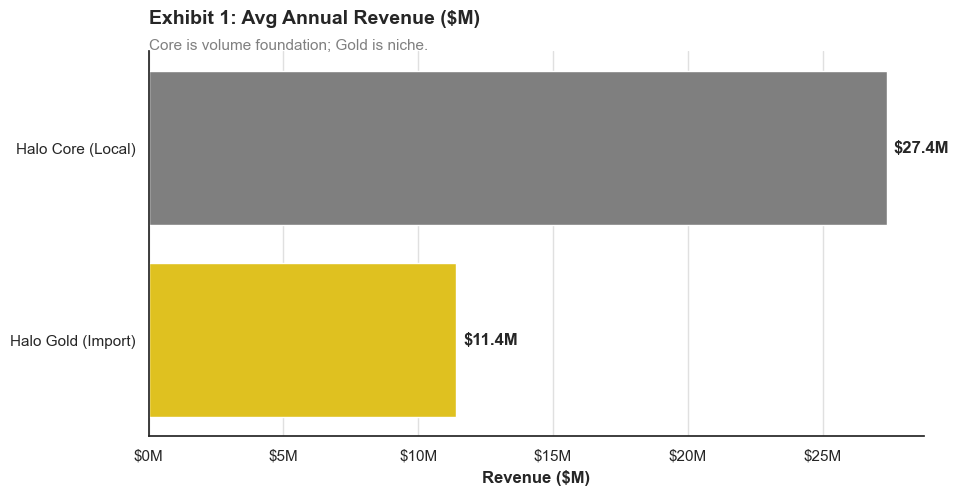

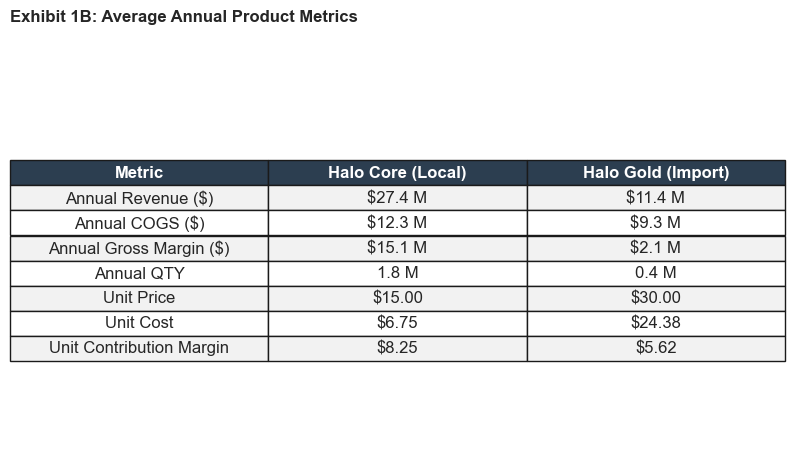

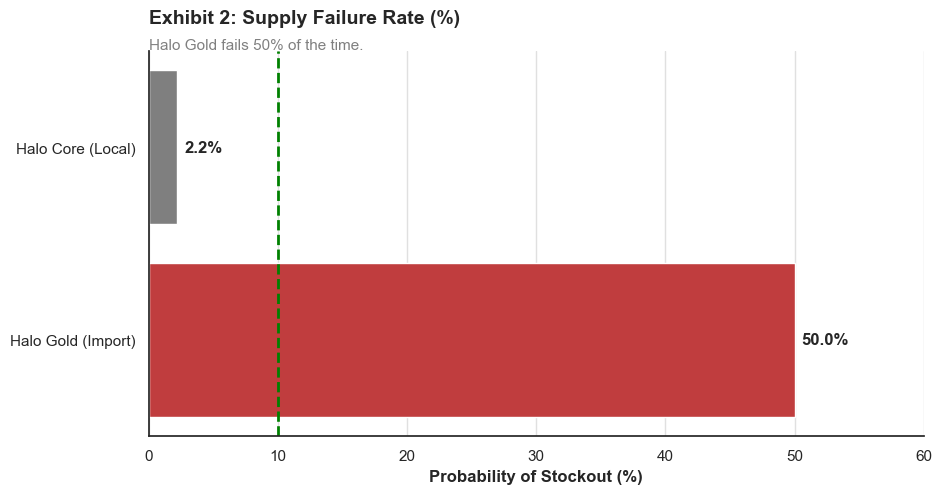

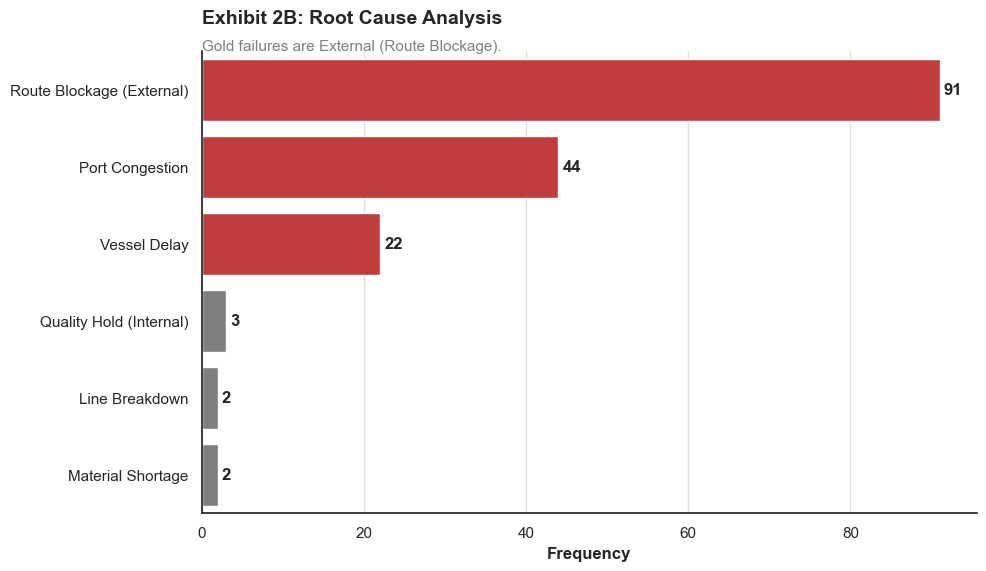

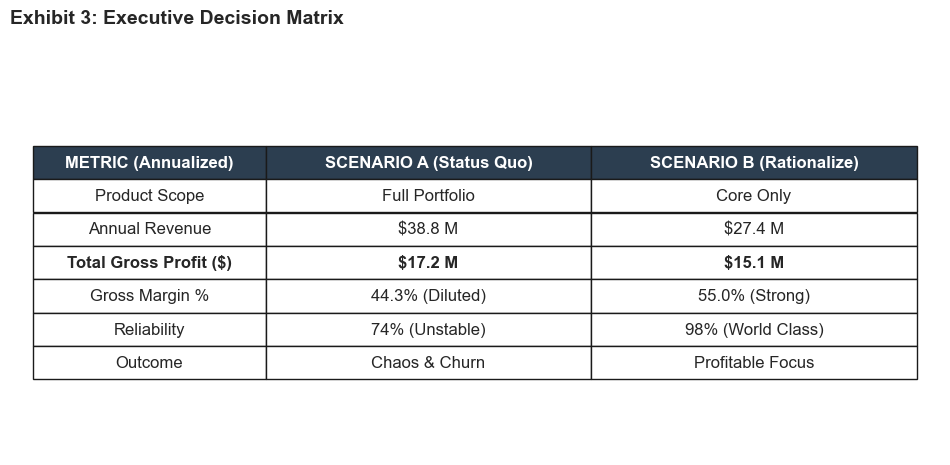

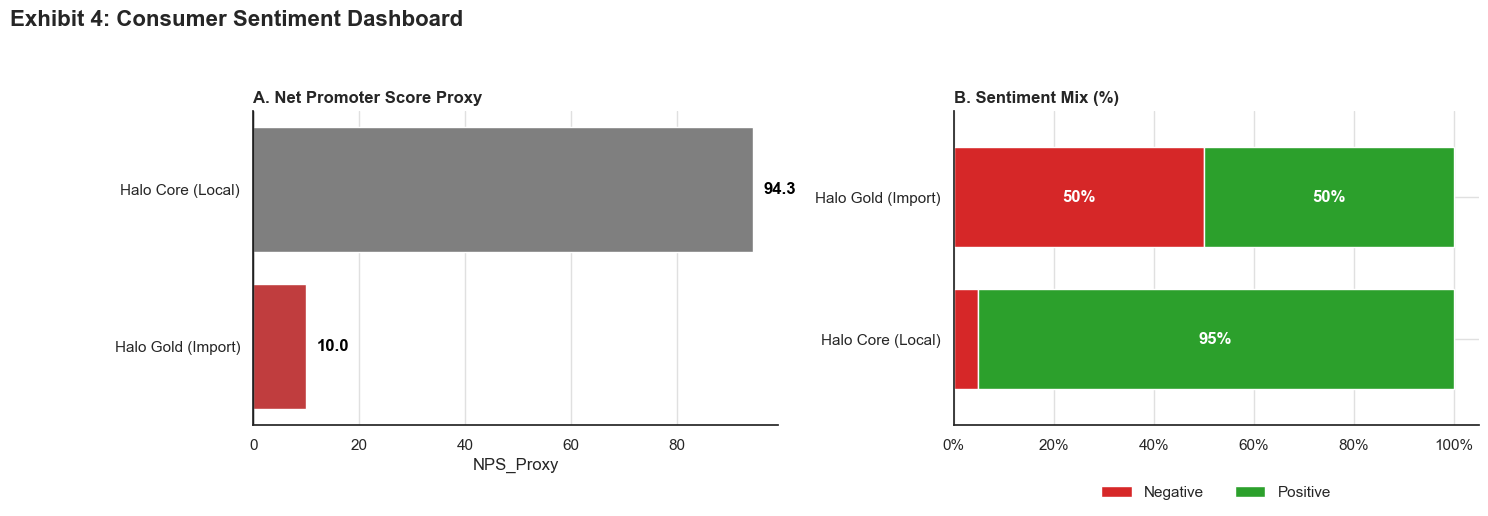

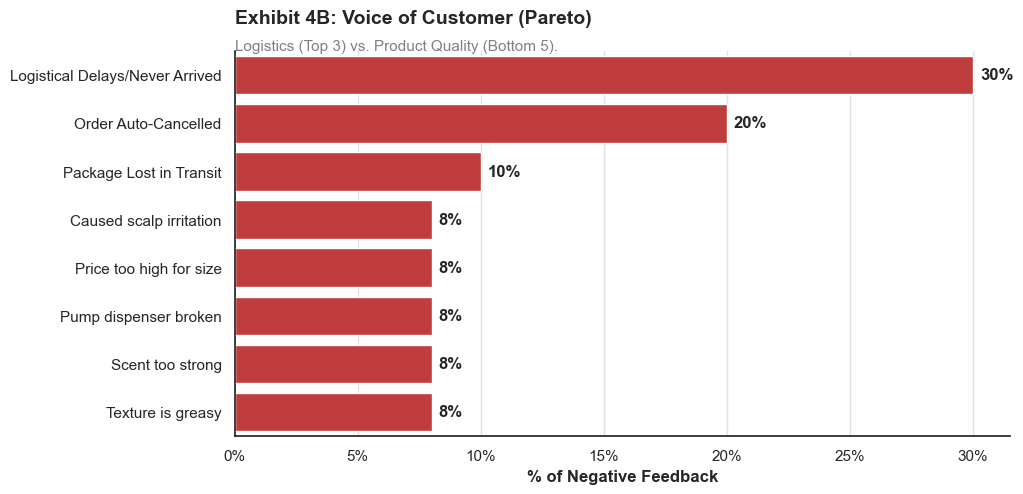

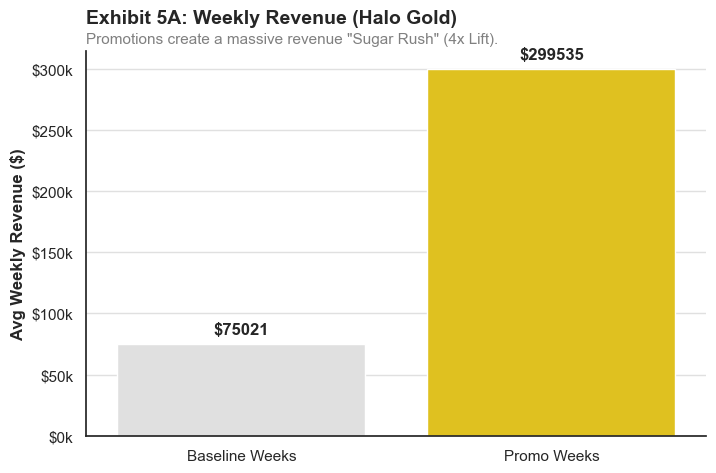

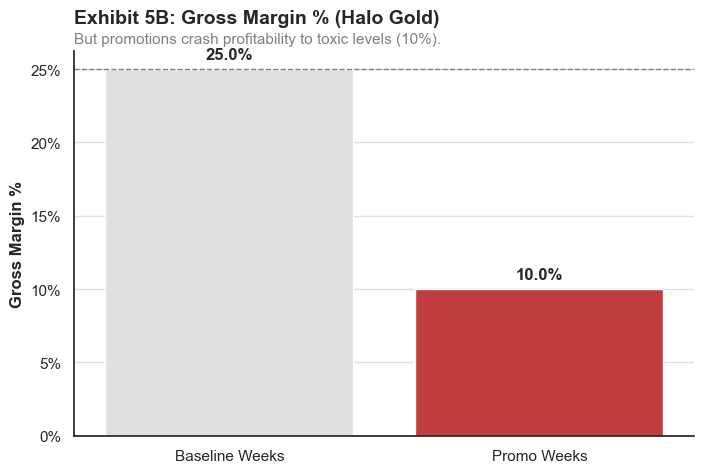

✅ Block 5 Complete: Visuals generated and exported.


In [14]:
print("--- GENERATING VISUALS ---")

# Global Style
sns.set_theme(style="white", rc={
    "axes.facecolor": (0,0,0,0), "axes.grid": True, 
    "grid.color": "#e0e0e0", "axes.spines.top": False, 
    "axes.spines.right": False
})
prod_order = ['Halo Core (Local)', 'Halo Gold (Import)']
palette_main = {'Halo Core (Local)': '#7f7f7f', 'Halo Gold (Import)': '#FFD700'}
palette_risk = {'Halo Core (Local)': '#7f7f7f', 'Halo Gold (Import)': '#d62728'}
palette_sent = {'Positive': '#2ca02c', 'Neutral': '#ff7f0e', 'Negative': '#d62728'}

def format_plot(ax, title, sub, x_lab, y_lab):
    ax.set_title(title, fontweight='bold', fontsize=14, loc='left', pad=20)
    ax.text(x=ax.get_xlim()[0], y=ax.get_ylim()[1]*1.02, s=sub, fontsize=11, color='grey')
    ax.set_xlabel(x_lab, fontweight='bold')
    ax.set_ylabel(y_lab, fontweight='bold')

# --- EXHIBIT 1: REVENUE ---
ex1 = df.groupby('Product_Type')['Revenue'].sum().reset_index()
ex1['Annual_Rev'] = ex1['Revenue'] / CONFIG['years_factor'] / 1e6

plt.figure(figsize=(10, 5))
ax1 = sns.barplot(data=ex1, x='Annual_Rev', y='Product_Type', hue='Product_Type', palette=palette_main, legend=False, order=prod_order)
format_plot(ax1, 'Exhibit 1: Avg Annual Revenue ($M)', 'Core is volume foundation; Gold is niche.', 'Revenue ($M)', '')
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:.0f}M'))
for container in ax1.containers: ax1.bar_label(container, fmt='$%.1fM', padding=5, fontweight='bold')

# SAVE FIRST, THEN SHOW
plt.savefig(f'{OUTPUT_DIR}/Exhibit_1_Revenue.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

# --- EXHIBIT 1B: METRICS TABLE ---
ex1b_agg = df.groupby('Product_Type').agg({'Revenue': 'sum', 'COGS': 'sum', 'Gross_Profit': 'sum', 'Final_Units': 'sum'})
ex1b_agg = ex1b_agg / CONFIG['years_factor']
ex1b_agg['Unit_Price'] = ex1b_agg['Revenue'] / ex1b_agg['Final_Units']
ex1b_agg['Unit_CM'] = ex1b_agg['Gross_Profit'] / ex1b_agg['Final_Units']
ex1b_agg['Unit_Cost'] = ex1b_agg['Unit_Price'] - ex1b_agg['Unit_CM']

table_rows = [
    ['Annual Revenue ($)', f"${ex1b_agg.loc[prod_order[0], 'Revenue']/1e6:.1f} M", f"${ex1b_agg.loc[prod_order[1], 'Revenue']/1e6:.1f} M"],
    ['Annual COGS ($)', f"${ex1b_agg.loc[prod_order[0], 'COGS']/1e6:.1f} M", f"${ex1b_agg.loc[prod_order[1], 'COGS']/1e6:.1f} M"],
    ['Annual Gross Margin ($)', f"${ex1b_agg.loc[prod_order[0], 'Gross_Profit']/1e6:.1f} M", f"${ex1b_agg.loc[prod_order[1], 'Gross_Profit']/1e6:.1f} M"],
    ['Annual QTY', f"{ex1b_agg.loc[prod_order[0], 'Final_Units']/1e6:.1f} M", f"{ex1b_agg.loc[prod_order[1], 'Final_Units']/1e6:.1f} M"],
    ['Unit Price', f"${ex1b_agg.loc[prod_order[0], 'Unit_Price']:.2f}", f"${ex1b_agg.loc[prod_order[1], 'Unit_Price']:.2f}"],
    ['Unit Cost', f"${ex1b_agg.loc[prod_order[0], 'Unit_Cost']:.2f}", f"${ex1b_agg.loc[prod_order[1], 'Unit_Cost']:.2f}"],
    ['Unit Contribution Margin', f"${ex1b_agg.loc[prod_order[0], 'Unit_CM']:.2f}", f"${ex1b_agg.loc[prod_order[1], 'Unit_CM']:.2f}"]
]

fig, ax1b = plt.subplots(figsize=(10, 5))
ax1b.axis('off')
tbl = ax1b.table(cellText=table_rows, colLabels=['Metric', 'Halo Core (Local)', 'Halo Gold (Import)'], loc='center', cellLoc='center')
tbl.auto_set_font_size(False); tbl.set_fontsize(12); tbl.scale(1, 1.5)
for i in range(3): tbl[(0, i)].set_facecolor('#2c3e50'); tbl[(0, i)].set_text_props(color='white', weight='bold')
for i in range(len(table_rows)): 
    if i % 2 == 0: 
        for j in range(3): tbl[(i+1, j)].set_facecolor('#f2f2f2')
plt.title('Exhibit 1B: Average Annual Product Metrics', fontweight='bold', loc='left', y=1.1)

plt.savefig(f'{OUTPUT_DIR}/Exhibit_1B_Metrics.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

# --- EXHIBIT 2: SUPPLY RISK ---
ex2 = df.groupby('Product_Type')['Stockout_Count'].mean().reset_index()
ex2['Fail_Rate'] = ex2['Stockout_Count'] * 100

plt.figure(figsize=(10, 5))
ax2 = sns.barplot(data=ex2, x='Fail_Rate', y='Product_Type', hue='Product_Type', palette=palette_risk, legend=False, order=prod_order)
format_plot(ax2, 'Exhibit 2: Supply Failure Rate (%)', 'Halo Gold fails 50% of the time.', 'Probability of Stockout (%)', '')
ax2.axvline(10, color='green', linestyle='--', linewidth=2)
ax2.set_xlim(0, 60)
for container in ax2.containers: ax2.bar_label(container, fmt='%.1f%%', padding=5, fontweight='bold')

plt.savefig(f'{OUTPUT_DIR}/Exhibit_2_Risk.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

# --- EXHIBIT 2B: ROOT CAUSE ---
rca = df[df['Stockout_Count']==1].groupby('Stockout_Reason').size().reset_index(name='Count').sort_values('Count', ascending=False)
colors_rca = [palette_risk['Halo Gold (Import)'] if x in gold_stockout_reasons else palette_main['Halo Core (Local)'] for x in rca['Stockout_Reason']]

plt.figure(figsize=(10, 6))
ax2b = sns.barplot(data=rca, x='Count', y='Stockout_Reason', hue='Stockout_Reason', palette=colors_rca, legend=False)
format_plot(ax2b, 'Exhibit 2B: Root Cause Analysis', 'Gold failures are External (Route Blockage).', 'Frequency', '')
for container in ax2b.containers: ax2b.bar_label(container, padding=3, fontweight='bold')

plt.savefig(f'{OUTPUT_DIR}/Exhibit_2B_Root_Cause.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

# --- EXHIBIT 3: DECISION MATRIX ---
tot_rev = df['Revenue'].sum() / CONFIG['years_factor']
core_rev = df[df['Product_Type'].str.contains('Core')]['Revenue'].sum() / CONFIG['years_factor']
tot_profit = df['Gross_Profit'].sum() / CONFIG['years_factor']
core_profit = df[df['Product_Type'].str.contains('Core')]['Gross_Profit'].sum() / CONFIG['years_factor']
tot_marg = tot_profit / tot_rev
core_marg = core_profit / core_rev
matrix_data = [
    ['METRIC (Annualized)', 'SCENARIO A (Status Quo)', 'SCENARIO B (Rationalize)'],
    ['Product Scope', 'Full Portfolio', 'Core Only'],
    ['Annual Revenue', f"${tot_rev/1e6:.1f} M", f"${core_rev/1e6:.1f} M"],
    ['Total Gross Profit ($)', f"${tot_profit/1e6:.1f} M", f"${core_profit/1e6:.1f} M"],
    ['Gross Margin %', f"{tot_marg:.1%} (Diluted)", f"{core_marg:.1%} (Strong)"],
    ['Reliability', "74% (Unstable)", "98% (World Class)"],
    ['Outcome', "Chaos & Churn", "Profitable Focus"]
]
fig, ax3 = plt.subplots(figsize=(12, 5))
ax3.axis('off')
table = ax3.table(cellText=matrix_data, loc='center', cellLoc='center', colWidths=[0.25, 0.35, 0.35])
table.auto_set_font_size(False); table.set_fontsize(12); table.scale(1, 2)
for i in range(3): table[(0, i)].set_facecolor('#2c3e50'); table[(0, i)].set_text_props(color='white', weight='bold')
for i in range(3): table[(3, i)].set_text_props(weight='bold')
plt.title('Exhibit 3: Executive Decision Matrix', fontweight='bold', y=1.1, fontsize=14, loc='left')

plt.savefig(f'{OUTPUT_DIR}/Exhibit_3_Decision_Matrix.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

# --- EXHIBIT 4: CONSUMER DASHBOARD ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plt.suptitle('Exhibit 4: Consumer Sentiment Dashboard', fontweight='bold', fontsize=16, y=1.05, x=0.1)

# Panel A: NPS
sns.barplot(data=nps_summary, x='NPS_Proxy', y='Product_Type', hue='Product_Type', palette=palette_risk, legend=False, ax=axes[0], order=prod_order)
axes[0].set_title('A. Net Promoter Score Proxy', fontweight='bold', loc='left')
axes[0].axvline(0, color='black', linewidth=1)
axes[0].set_ylabel('')
for p in axes[0].patches:
    width = p.get_width()
    if width < 0: axes[0].text(width + 8, p.get_y() + p.get_height()/2, f'{width:.1f}', va='center', ha='left', weight='bold', color='black')
    else: axes[0].text(width + 2, p.get_y() + p.get_height()/2, f'{width:.1f}', va='center', ha='left', weight='bold', color='black')

# Panel B: Sentiment Mix
sent_mix = df_sentiment.groupby(['Product_Type', 'Sentiment_Category']).size().unstack(fill_value=0).reindex(prod_order)[['Negative', 'Positive']]
sent_mix_pct = sent_mix.div(sent_mix.sum(axis=1), axis=0) * 100
sent_mix_pct.plot(kind='barh', stacked=True, ax=axes[1], color=[palette_sent['Negative'], palette_sent['Positive']], width=0.7)
axes[1].set_title('B. Sentiment Mix (%)', fontweight='bold', loc='left')
axes[1].set_ylabel('')
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
for n, x in enumerate(sent_mix.index):
    for (cn, cen) in enumerate(sent_mix_pct.loc[x]):
        if cen > 5: axes[1].text(sent_mix_pct.loc[x][:cn].sum() + (cen/2), n, f'{cen:.0f}%', va='center', ha='center', color='white', weight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/Exhibit_4_Consumer.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

# --- EXHIBIT 4B: VoC PARETO ---
voc_data = df_sentiment[(df_sentiment['Product_Type'].str.contains('Gold')) & (df_sentiment['Sentiment_Category']=='Negative')]
voc_counts = voc_data.groupby('VoC_Category').size().reset_index(name='Count').sort_values('Count', ascending=False)
voc_counts['Percentage'] = voc_counts['Count'] / voc_counts['Count'].sum() * 100

plt.figure(figsize=(10, 5))
ax4b = sns.barplot(data=voc_counts, x='Percentage', y='VoC_Category', color=palette_risk['Halo Gold (Import)'])
format_plot(ax4b, 'Exhibit 4B: Voice of Customer (Pareto)', 'Logistics (Top 3) vs. Product Quality (Bottom 5).', '% of Negative Feedback', '')
ax4b.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
for container in ax4b.containers: ax4b.bar_label(container, fmt='%.0f%%', padding=5, weight='bold')

plt.savefig(f'{OUTPUT_DIR}/Exhibit_4B_VoC_Pareto.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

# --- EXHIBIT 5: THE PROMO TRAP (SPLIT INTO 5A & 5B) ---
promo_data = df.groupby(['Product_Type', 'Promo_Flag']).agg({'Revenue': 'mean', 'Gross_Margin_Pct': 'mean'}).reset_index()
promo_data['Scenario'] = promo_data['Promo_Flag'].map({0: 'Baseline Weeks', 1: 'Promo Weeks'})
promo_data['Margin_Show'] = promo_data['Gross_Margin_Pct'] * 100
gold_promo = promo_data[promo_data['Product_Type'].str.contains('Gold')].copy()

# EXHIBIT 5A: WEEKLY REVENUE
plt.figure(figsize=(8, 5))
ax5a = sns.barplot(data=gold_promo, x='Scenario', y='Revenue', hue='Scenario', palette=['#e0e0e0', '#FFD700'], legend=False)
format_plot(ax5a, 'Exhibit 5A: Weekly Revenue (Halo Gold)', 'Promotions create a massive revenue "Sugar Rush" (4x Lift).', '', 'Avg Weekly Revenue ($)')
ax5a.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
for container in ax5a.containers: ax5a.bar_label(container, fmt='$%.0f', padding=5, weight='bold')

plt.savefig(f'{OUTPUT_DIR}/Exhibit_5A_Promo_Revenue.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

# EXHIBIT 5B: GROSS MARGIN
plt.figure(figsize=(8, 5))
ax5b = sns.barplot(data=gold_promo, x='Scenario', y='Margin_Show', hue='Scenario', palette=['#e0e0e0', '#d62728'], legend=False)
format_plot(ax5b, 'Exhibit 5B: Gross Margin % (Halo Gold)', 'But promotions crash profitability to toxic levels (10%).', '', 'Gross Margin %')
ax5b.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
for container in ax5b.containers: ax5b.bar_label(container, fmt='%.1f%%', padding=5, weight='bold')
ax5b.axhline(25, color='grey', linestyle='--', linewidth=1, label='Break-even Target')

plt.savefig(f'{OUTPUT_DIR}/Exhibit_5B_Promo_Margin.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

print("✅ Block 5 Complete: Visuals generated and exported.")

---
## **Block 6: Exporting Files**
**What this does:** Saves the results to the output folder.

1.  **Answer Keys:** Summarized CSVs for the Facilitator to check answers.
2.  **Student Files:** Raw data (Transactions & Feedback) for students to analyze in Excel/PowerBI.
3.  **Readme:** Instructions on how to use the files.

In [15]:
print("--- EXPORTING FILES ---")

# Answer Keys
df.groupby('Product_Type')['Revenue'].sum().reset_index().to_csv(f'{OUTPUT_DIR}/Key_1_Revenue.csv', index=False)
ex1b_agg.reset_index().to_csv(f'{OUTPUT_DIR}/Key_1B_Detailed_Metrics.csv', index=False)
df.groupby('Product_Type')['Stockout_Count'].mean().reset_index().to_csv(f'{OUTPUT_DIR}/Key_2_Risk.csv', index=False)
df[df['Stockout_Count']==1].groupby(['Product_Type', 'Stockout_Reason']).size().reset_index(name='Count').to_csv(f'{OUTPUT_DIR}/Key_2B_Root_Cause.csv', index=False)
nps_summary.to_csv(f'{OUTPUT_DIR}/Key_4_Consumer_NPS.csv', index=False)
voc_counts.to_csv(f'{OUTPUT_DIR}/Key_4B_VoC_Pareto.csv', index=False)
promo_data.to_csv(f'{OUTPUT_DIR}/Key_5_Promo_Analysis.csv', index=False)

# Master Data Files
df.sort_values(by=['Date', 'SKU']).to_csv(f'{OUTPUT_DIR}/SOP_Master_Training_Data.csv', index=False)
df_sentiment.to_csv(f'{OUTPUT_DIR}/SOP_Consumer_Feedback_Raw.csv', index=False)

# README
metadata = f"""
S&OP WORKSHOP: EXCEL REPLICATION GUIDE
======================================
DATA FILES:
1. SOP_Master_Training_Data.csv (Transactions)
2. SOP_Consumer_Feedback_Raw.csv (Sentiment & VoC)

HOW TO BUILD THE EXHIBITS:
--------------------------
EXHIBIT 1 (Revenue): Pivot Sum 'Revenue' by 'Product_Type' from Transactions.
EXHIBIT 1B (Detailed Metrics): Pivot Sum 'Revenue', 'COGS', 'Gross_Profit', 'Final_Units' by 'Product_Type'.
EXHIBIT 2 (Risk): Pivot Avg 'Stockout_Count' by 'Product_Type'.
EXHIBIT 2B (Root Cause): Filter Stockout=1. Pivot Count 'Stockout_Reason'.
EXHIBIT 4 (NPS): Pivot Avg 'NPS_Score' by 'Product_Type' from Consumer Data.
EXHIBIT 4B (VoC): Filter for Gold & Negative. Pivot Count 'VoC_Category'. Sort Descending.
EXHIBIT 5A/5B (Promo): Pivot Avg 'Revenue' & 'Gross_Margin_Pct' by 'Product_Type' & 'Promo_Flag'.

SCENARIO NOTES:
- Halo Gold fails 50% due to "Route Blockage".
- Negative VoC is 60% Logistics (Signal) and 40% Product Quality (Noise).
- Promos drive 4x Revenue (Ex 5A) but crash Margin to 10% (Ex 5B).
"""
with open(f'{OUTPUT_DIR}/00_README_Excel_Guide.txt', 'w') as f:
    f.write(metadata)

print("✅ Block 6 Complete: Repository Ready.")

--- EXPORTING FILES ---
✅ Block 6 Complete: Repository Ready.
